In [13]:
from data.gen_data import build_X, build_Y, build_XY
from data.gen_data_config import gen_data_config
from evaluation import score
import pandas as pd
import numpy as np
from util import plot_roi, categori_reverse
from model import build_model
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
import keras
from pickle import load, dump
import matplotlib.pyplot as plt

In [14]:
embedding_dim = 32
batch_size = 128
epochs = 300

In [15]:
tr_s, tr_e = '2001/1/1', '2018/12/31'
te_s, te_e = '2019/1/1', '2019/12/31'
feature_days = 5
result_roi = {
    'rnn': {},
    'dense': {}
}

In [16]:
with open(f'./embedding_data/rnn_{embedding_dim}_v2_{feature_days}', 'rb') as f:
    embed_rnn = load(f)

In [17]:
_, tr_y, tr_result = build_XY(tr_s, tr_e, 
                                     gen_data_config['selected_features'], 
                                     feature_days, 2)
te_x, te_y, te_result = build_XY(te_s, te_e, 
                                 gen_data_config['selected_features'], 
                                 feature_days, 2)
# convert class vectors to binary class matrices
one_tr_y = keras.utils.to_categorical(tr_y, 3)
one_te_y = keras.utils.to_categorical(te_y, 3)

In [18]:
for task in ['1', '2']:
    '''rnn model'''
    tr_x = embed_rnn['data'][task]
    te_x = embed_rnn['tar'][task]
    re_tr_x = np.reshape(tr_x, (-1, 1, embedding_dim))
    re_te_x = np.reshape(te_x, (-1, 1, embedding_dim))
    
    model_rnn = build_model('rnn' ,re_tr_x.shape, one_tr_y.shape)
    
    ''' Compile model with specified loss and optimizer '''
    model_rnn.compile(loss= 'categorical_crossentropy',
                       optimizer='Adam',
                       metrics=['accuracy'])


    '''Fit models and use validation_split=0.1 '''
    history = model_rnn.fit(re_tr_x, one_tr_y,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=0,
                                  shuffle=True,
                                  validation_split=0.1,)
    
    pred_y = model_rnn.predict(re_te_x)
    pred_z = categori_reverse(pred_y)
    result_roi['rnn'][task] = score(pred_z, te_result)
    
    '''dense model'''
    
    model_dense = build_model('dense' ,tr_x.shape, one_tr_y.shape)

    ''' Compile model with specified loss and optimizer '''
    model_dense.compile(loss= 'categorical_crossentropy',
                       optimizer='Adam',
                       metrics=['accuracy'])

    '''Fit models and use validation_split=0.1 '''
    history = model_dense.fit(tr_x, one_tr_y,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=0,
                                  shuffle=True,
                                  validation_split=0.1,)
    pred_y = model_dense.predict(te_x)
    pred_z = categori_reverse(pred_y)
    result_roi['dense'][task] = score(pred_z, te_result)

#2action_day: 52, #3consecutive_loss_max: -170, #4consecutive_loss_days_max: 6, #5loss_days: 35, roi: -72, roi_max: 217, roi_min: -102
#2action_day: 99, #3consecutive_loss_max: -171, #4consecutive_loss_days_max: 7, #5loss_days: 60, roi: 1, roi_max: 248, roi_min: -149
#2action_day: 74, #3consecutive_loss_max: -187, #4consecutive_loss_days_max: 7, #5loss_days: 53, roi: -332, roi_max: 95, roi_min: -332
#2action_day: 127, #3consecutive_loss_max: -178, #4consecutive_loss_days_max: 8, #5loss_days: 82, roi: -93, roi_max: 189, roi_min: -117


In [20]:
roi_df_dict = {
    'rnn': {},
    'dense': {}
}
for t in ['1', '2']:
    roi_df_dict['rnn'][t] = plot_roi(result_roi['rnn'][t], te_result)
    roi_df_dict['dense'][t] = plot_roi(result_roi['dense'][t], te_result)

Text(0.5, 0.98, 'embedding dim 32')

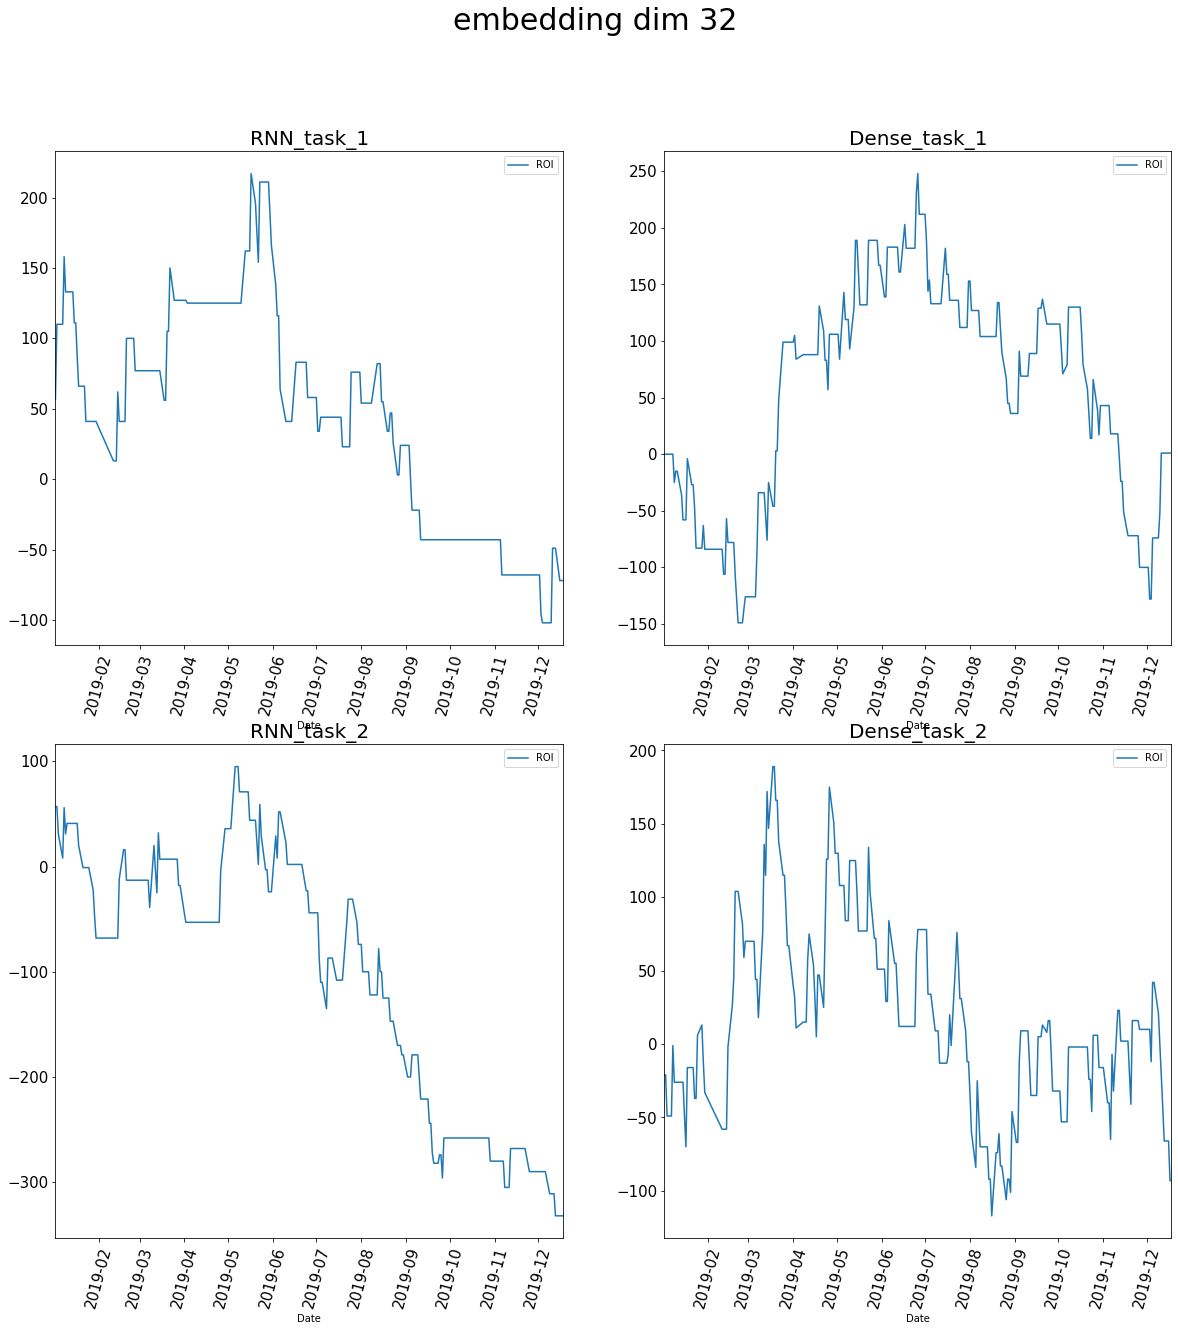

In [22]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


for i, t in zip(range(1,3), ['1', '2']):
    i = i*2
    left, right = i-1, i
    roi_df_dict['rnn'][t].plot(rot=75,ax = locals()[f'ax{left}'], fontsize=15)
    roi_df_dict['dense'][t].plot(rot=75,ax = locals()[f'ax{right}'], fontsize=15)
    locals()[f'ax{left}'].set_title(f'RNN_task_{t}', fontsize=20)
    locals()[f'ax{right}'].set_title(f'Dense_task_{t}', fontsize=20)
fig.suptitle(f'embedding dim {embedding_dim}', fontsize=30)